In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Embedding,LSTM,Dense,Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from joblib import dump
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
import string

In [2]:
data = pd.read_csv('Twitter_Data.csv')

In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RAJVI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
data.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [6]:
data.isnull()

,textID,text,selected_text,sentiment
0,False,False,False,False
1,False,False,False,False
2,False,False,False,False
3,False,False,False,False
4,False,False,False,False
...,...,...,...,...
27476,False,False,False,False
27477,False,False,False,False
27478,False,False,False,False
27479,False,False,False,False


In [7]:
def clean_text(text):
    text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub(r'http\S+', '', text)
    stop = set(stopwords.words('english'))
    punctuation = list(string.punctuation)
    stop.update(punctuation)
    final_text = []
    for word in text.split():
        if word.strip().lower() not in stop:
            final_text.append(word.strip())
    cleaned_text = " ".join(final_text)
    # Check if the cleaned text is empty
    if not cleaned_text:
        cleaned_text = "placeholder"  # Add a placeholder word

    return cleaned_text

data["text"] = data["text"].astype(str)
data['clean_text'] = data['text'].apply(clean_text)


C:\Users\RAJVI\AppData\Local\Temp\ipykernel_9900\454591771.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


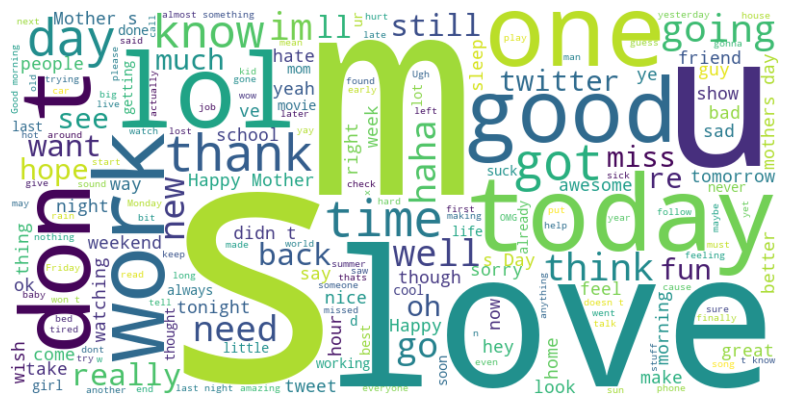

In [8]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text_data = " ".join(review for review in data ['clean_text'])

wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(text_data)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()



In [9]:
X = data['clean_text']
Y = data['sentiment']

In [10]:
unique_sentiments = Y.unique()
print("unique sentiments:" , unique_sentiments)

Y=  Y.replace({'negative':0 , 'neutral':1 , 'positive':2})

unique sentiments: ['neutral' 'negative' 'positive']


C:\Users\RAJVI\AppData\Local\Temp\ipykernel_9900\3253933817.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Y=  Y.replace({'negative':0 , 'neutral':1 , 'positive':2})


In [11]:
x_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

In [12]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(x_train)
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(X_test)
x_train_pad = pad_sequences(x_train_seq , maxlen=100,padding='post')
x_test_pad = pad_sequences(x_test_seq , maxlen=100,padding='post')




In [13]:
label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)
Y_test_encoded = label_encoder.transform(Y_test)



In [14]:
num_classes = len(unique_sentiments)
Y_train_onehot = tf.keras.utils.to_categorical(Y_train_encoded,num_classes=num_classes)
Y_test_onehot = tf.keras.utils.to_categorical(Y_test_encoded,num_classes=num_classes)



In [15]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization
# Build a simple LSTM model with 3 output units
model = tf.keras.Sequential([
    Embedding(input_dim=5000, output_dim=100, input_length=100),
    LSTM(128),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Train the model with a reduced batch size
model.fit(x_train_pad, Y_train_onehot, epochs=5, batch_size=32, validation_data=(x_test_pad, Y_test_onehot))
 

c:\Users\RAJVI\anaconda3\envs\pin\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
687/687 ━━━━━━━━━━━━━━━━━━━━ 47s 63ms/step - accuracy: 0.4002 - loss: 1.0908 - val_accuracy: 0.4057 - val_loss: 1.0870
Epoch 2/5
687/687 ━━━━━━━━━━━━━━━━━━━━ 40s 59ms/step - accuracy: 0.4087 - loss: 1.0867 - val_accuracy: 0.4057 - val_loss: 1.0866
Epoch 3/5
687/687 ━━━━━━━━━━━━━━━━━━━━ 41s 60ms/step - accuracy: 0.3973 - loss: 1.0891 - val_accuracy: 0.4057 - val_loss: 1.0867
Epoch 4/5
687/687 ━━━━━━━━━━━━━━━━━━━━ 42s 61ms/step - accuracy: 0.4010 - loss: 1.0881 - val_accuracy: 0.4057 - val_loss: 1.0867
Epoch 5/5
687/687 ━━━━━━━━━━━━━━━━━━━━ 43s 63ms/step - accuracy: 0.4028 - loss: 1.0878 - val_accuracy: 0.4057 - val_loss: 1.0867


In [16]:
# Build a deeper LSTM model with regularization
model = tf.keras.Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100),  # Increased embedding dimension
    LSTM(128, return_sequences=True),                             # First LSTM layer with return_sequences=True
    Dropout(0.3),
    LSTM(64, return_sequences=True),                              # Second LSTM layer to learn complex patterns
    Dropout(0.2),
    LSTM(32),                                                     # Final LSTM layer
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),  # Dense layer with L2 regularization
    Dropout(0.2),
    Dense(num_classes, activation='sigmoid')                      # Output layer with softmax for multi-class classification
])

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with increased epochs and a smaller batch size
model.fit(x_train_pad, Y_train_onehot, epochs=10, batch_size=64, validation_data=(x_test_pad, Y_test_onehot))


Epoch 1/10


c:\Users\RAJVI\anaconda3\envs\pin\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 86s 234ms/step - accuracy: 0.4008 - loss: 1.1166 - val_accuracy: 0.4057 - val_loss: 1.0949
Epoch 2/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 73s 212ms/step - accuracy: 0.4063 - loss: 1.0921 - val_accuracy: 0.4057 - val_loss: 1.0890
Epoch 3/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 75s 219ms/step - accuracy: 0.4028 - loss: 1.0899 - val_accuracy: 0.4057 - val_loss: 1.0876
Epoch 4/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 74s 216ms/step - accuracy: 0.4061 - loss: 1.0878 - val_accuracy: 0.4057 - val_loss: 1.0876
Epoch 5/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 76s 220ms/step - accuracy: 0.4063 - loss: 1.0870 - val_accuracy: 0.4057 - val_loss: 1.0869
Epoch 6/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 76s 222ms/step - accuracy: 0.4060 - loss: 1.0868 - val_accuracy: 0.4057 - val_loss: 1.0867
Epoch 7/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 79s 229ms/step - accuracy: 0.4051 - loss: 1.0869 - val_accuracy: 0.4057 - val_loss: 1.0867
Epoch 8/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 80s 232ms/step - accuracy: 0.4028 - loss: 1.0876 - val

In [17]:
# Save the trained model
model.save('sentiment_model.h5')
dump(tokenizer, 'tokenizer.joblib')

['tokenizer.joblib']

In [18]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load the saved model
model = tf.keras.models.load_model('sentiment_model.h5')

# Load the tokenizer
tokenizer = Tokenizer(num_words=5000)  # Set the same number as used during training

# Define the maximum sequence length (same as used during training)
max_length = 100

# Function to predict sentiment
def predict_sentiment(text):
    # Tokenize and pad the input text
    sequences = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(sequences, maxlen=max_length, truncating='post')

    # Predict the sentiment
    prediction = model.predict(padded)

    return prediction

# Static input text
sample_text = "I loved the movie! It was fantastic and had a great storyline."

# Predict sentiment for the static input
prediction = predict_sentiment(sample_text)
print("prediction----",prediction)
# Determine the sentiment based on the prediction
sentiment = ["Negative", "Neutral", "Positive"][prediction.argmax()]

# Display the result
print(f"Text: {sample_text}")
print(f"Predicted Sentiment: {sentiment}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
prediction---- [[0.45347744 0.5433173  0.4848445 ]]
Text: I loved the movie! It was fantastic and had a great storyline.
Predicted Sentiment: Neutral


In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import tensorflow as tf
from joblib import dump

# Split the data into training and testing sets
x_train, x_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Use TF-IDF to vectorize the text data
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(x_train).toarray()
X_test_tfidf = tfidf.transform(x_test).toarray()

# Save the TF-IDF vectorizer
dump(tfidf, 'tfidf_vectorizer.joblib')

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(Y_train)
y_test_encoded = label_encoder.transform(Y_test)

# One-hot encode labels
num_classes = len(unique_sentiments)
y_train_onehot = tf.keras.utils.to_categorical(y_train_encoded, num_classes=num_classes)
y_test_onehot = tf.keras.utils.to_categorical(y_test_encoded, num_classes=num_classes)

# Build a simple dense neural network model for classification
model = Sequential([
    Dense(128, input_shape=(5000,), activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_tfidf, y_train_onehot, epochs=5, batch_size=32, validation_data=(X_test_tfidf, y_test_onehot))


c:\Users\RAJVI\anaconda3\envs\pin\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
687/687 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5024 - loss: 0.9793 - val_accuracy: 0.6987 - val_loss: 0.7250
Epoch 2/5
687/687 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7387 - loss: 0.6568 - val_accuracy: 0.6978 - val_loss: 0.7162
Epoch 3/5
687/687 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.7954 - loss: 0.5449 - val_accuracy: 0.6937 - val_loss: 0.7394
Epoch 4/5
687/687 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8326 - loss: 0.4548 - val_accuracy: 0.6829 - val_loss: 0.7811
Epoch 5/5
687/687 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8652 - loss: 0.3796 - val_accuracy: 0.6771 - val_loss: 0.8370
